# Denoising Diffusion Probabilistic Models with miniai

## Imports

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *
import miniai.fastprogressfix

/home/joey/mambaforge/envs/fastai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)
set_seed(42)
# if fc.defaults.cpus>8: fc.defaults.cpus=8
def_device

'cuda'

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [4]:
from types import SimpleNamespace

In [5]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [6]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

In [7]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

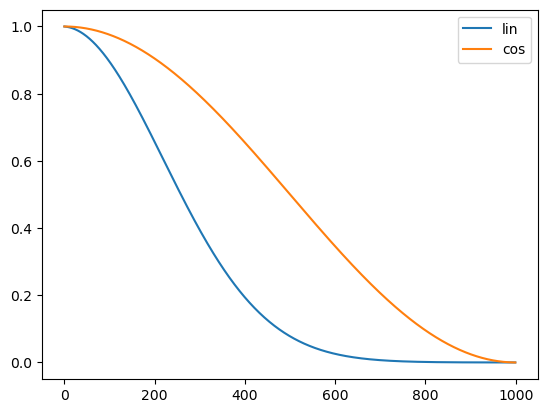

In [8]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

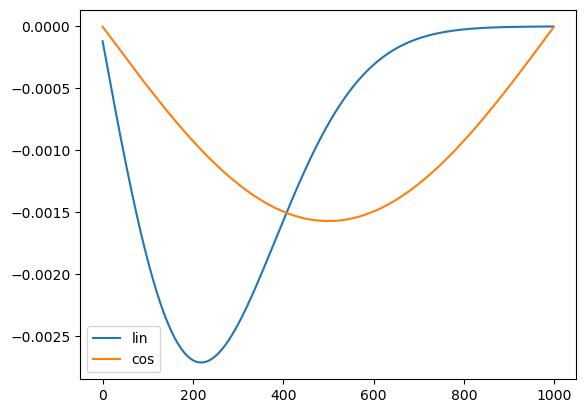

In [9]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

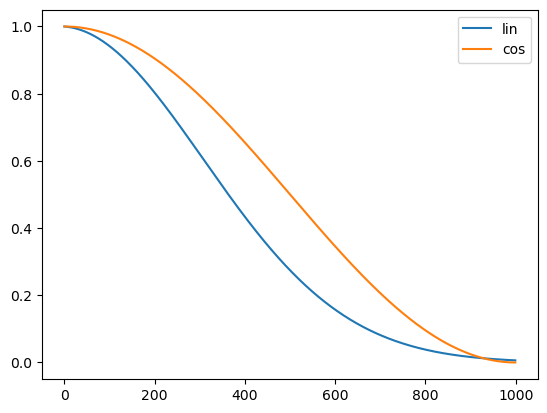

In [10]:
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

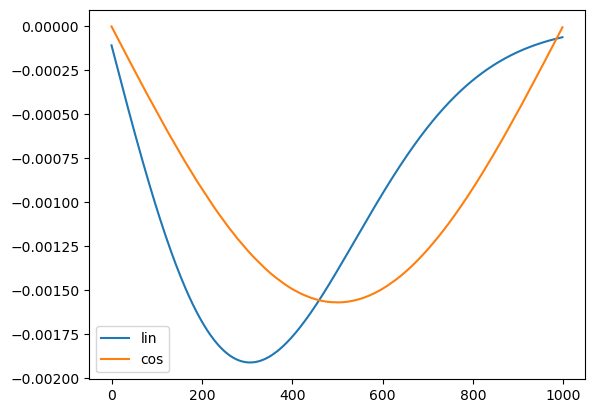

In [11]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

In [12]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [13]:
def noisify(x0, alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [14]:
dt = dls.train
xb,yb = next(iter(dt))

In [15]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([ 26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295,
        567, 706, 749, 876,  73, 111, 899, 213, 541, 769, 287])

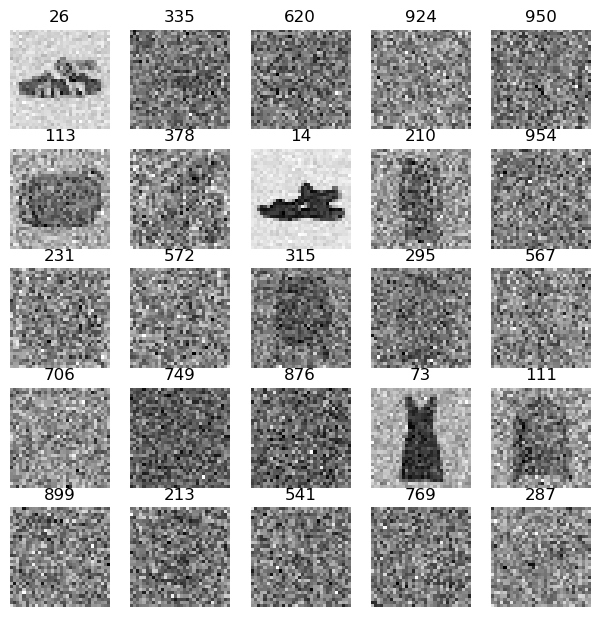

In [16]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

## Training

In [17]:
from diffusers import UNet2DModel

In [18]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [19]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [20]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [21]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [22]:
lr = 1e-2
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [23]:
def_device

'cuda'

In [24]:
# learn.fit(epochs) # 0.022	24	eval

In [25]:
mdl_path = Path('models')

In [26]:
# torch.save(learn.model, mdl_path/'fashion_ddpm3_25.pkl')

In [27]:
torch.cuda.is_available()
def_device

'cuda'

In [28]:
model = torch.load(mdl_path/'fashion_ddpm3_25.pkl')#.cuda()

In [29]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [30]:
n_samples = 512

In [31]:
%%time
samples = sample(model, (n_samples, 1, 32, 32))

CPU times: user 6min 16s, sys: 597 ms, total: 6min 17s
Wall time: 6min 17s


In [32]:
s = (samples[-1]*2)#.clamp(-1,1)
s.min(),s.max()

(tensor(-1.1167), tensor(1.2714))

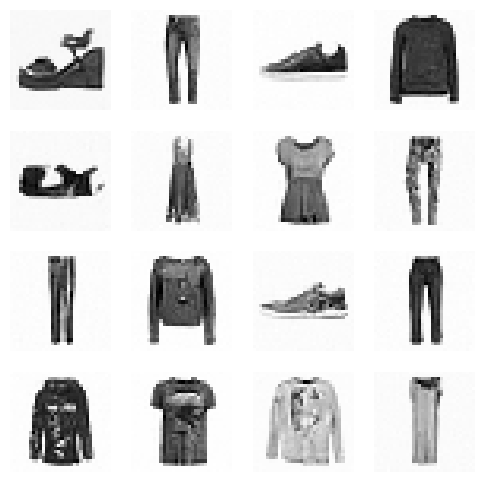

In [33]:
show_images(s[:16], imsize=1.5)

In [34]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [35]:
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [37]:
ie.fid(s), ie.fid2(s)

(2.1973876953125, 48.80055372927051)

In [ ]:
s.min(),s.max()

(tensor(-1.0903), tensor(1.2727))

In [38]:
ie.fid(xb*2), ie.fid2(xb*2)

(-2.4415283203125, 45.72879684231261)

### Skip sampling

In [ ]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t%3==0 or t<50: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().float())
    return preds

In [ ]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

CPU times: user 2min 24s, sys: 2.61 s, total: 2min 26s
Wall time: 2min 26s


In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)

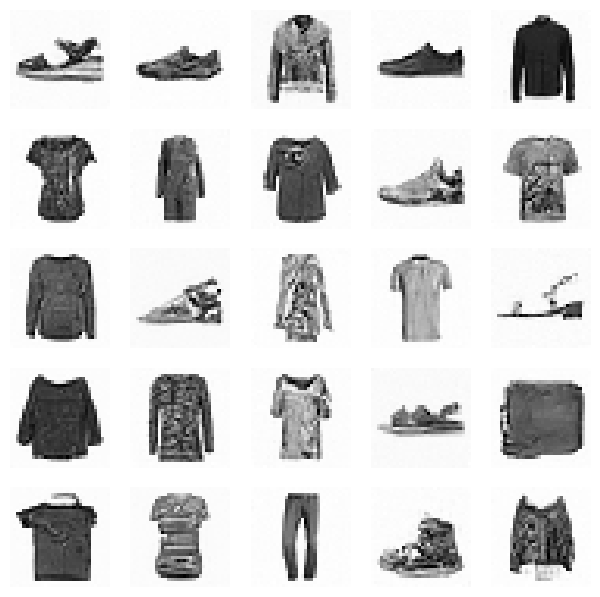

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s), calc

-0.4071044921875

In [ ]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample2(model, (n_samples, 1, 32, 32))

CPU times: user 1min 58s, sys: 47.9 ms, total: 1min 58s
Wall time: 1min 58s


In [ ]:
s = (samples[-1]*2)#.clamp(-1,1)

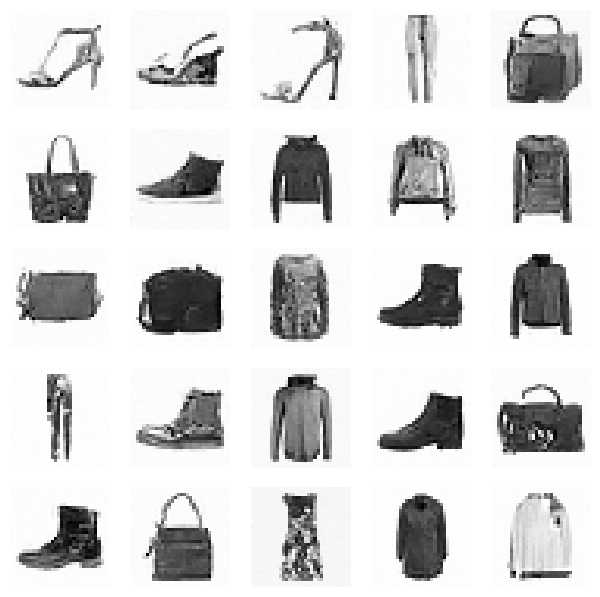

In [ ]:
show_images(s[:25], imsize=1.5)

In [ ]:
ie.fid(s)

2.4373779296875